In [1]:
import time
import datetime as dt

def epoch_to_millis(epoch):
    
    datetime_time = dt.datetime.fromtimestamp(epoch)
    s = (datetime_time - dt.datetime(1970, 1, 1)).total_seconds()-3600
               
    return s
    

In [2]:
#import e parsing file di log
import pandas as pd

def start(path):
    
    file = open(path, 'r')
    Lines = file.readlines()
    
    return Lines

def rmse_distance(Lines):
    
    coppie = []

    for line in Lines:
        
        if 'COUPLE(N_ITER,DISTANCE RMSE)' in line:
            split = line.split(':')
            s = split[3].replace('[','')
            s = s.replace('(','')
            s = s.replace(')','')
            s = s.replace(']','')
            s = s.split(',')
            a = int(s[0])
            b = float(s[1])
            coppie.append((a,b))          
        
    return coppie

def tensorflow_chis(lines):

    lista = []
    chis = []
    
    for line in lines:
        
        if 'TENSORFLOW_CHIS' in line:
            split = line.split(':')
            s = split[3].replace('[','')
            s = s.replace(']','')
            lista = [float(n) for n in s.split(',')]
            chis.append(lista)

    return chis


def gurobi_chis(lines):
    
    chis = []
    
    for line in lines:
        
        if 'GUROBI_CHIS' in line:
            split = line.split(':')
            s = split[3].replace('[','')
            s = s.replace(']','')
            chis = [float(n) for n in s.split(',')]

    return chis


def execution_time_gurobi(Lines):
    
    for line in Lines:
        
        if 'TEMPO_ESECUZIONE GUROBI' in line:
            split = line.split(':')
            
    return epoch_to_millis(float(split[3]))
    
    
def execution_time_tensorflow(Lines):
    
    for line in Lines:
        if 'TEMPO_ESECUZIONE TENSORFLOW' in line:
            split = line.split(':')
            
    return epoch_to_millis(float(split[3]))



In [3]:
import sklearn.datasets as ds
import pandas as pd

def create_dataset(name):

    #load dataset, in iris_X values, in iris_y labels 0 1 2
    iris_X, iris_y = ds.load_iris(return_X_y=True)  

    labels = ("Setosa", "Versicolor", "Virginica") 

    #dataframe with correct labels for respective values
    df = pd.DataFrame(iris_X, columns=["Sepal length", "Sepal width",
                                       "Petal length", "Petal width"])

    #associating 
    df['Class'] = iris_y
    df['Class'] = df['Class'].map(lambda c: labels[c])

    #dataset copy for labels 0 1
    selected_iris_dataset = iris_y.copy()

    #dataset selected with labels
    if(name == "Setosa"):        
        selected_iris_dataset[selected_iris_dataset != 0] = 2
        selected_iris_dataset[selected_iris_dataset == 0] = 1
        selected_iris_dataset[selected_iris_dataset == 2] = 0
    elif(name == "Versicolor"):
        selected_iris_dataset[selected_iris_dataset==2] = 0    
    elif(name == "Virginica"):
        selected_iris_dataset[selected_iris_dataset != 2] = 0
        selected_iris_dataset[selected_iris_dataset == 2] = 1


    return iris_X, selected_iris_dataset, iris_y

In [4]:
iris_X, selected_iris_dataset, iris_y = create_dataset("Setosa")

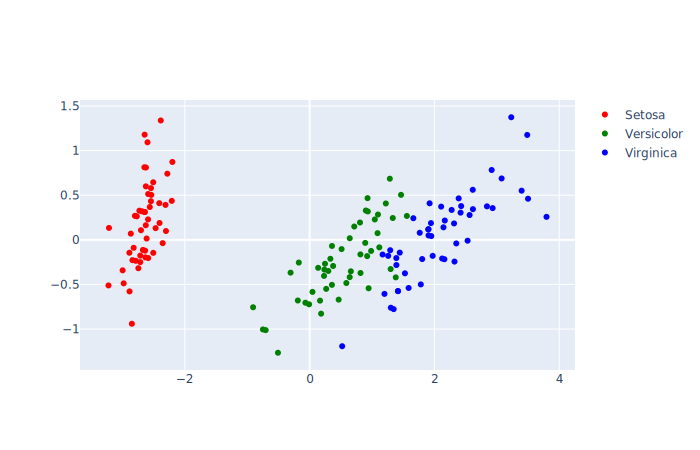

In [5]:
from sklearn.decomposition import PCA

pca_2d = PCA(n_components=2)
iris_X_2d = pca_2d.fit_transform(iris_X)

import plotly.graph_objects as go

def gr_dataset(fig): 
    labels = ("Setosa", "Versicolor", "Virginica")
    for lab, col in enumerate(("red", "green", "blue")):
        fig.add_trace(go.Scatter(x=iris_X_2d[iris_y==lab, 0],
                                 y=iris_X_2d[iris_y==lab, 1],
                                 mode="markers",
                                 marker_color=col,
                                 name=labels[lab]))

fig = go.Figure()
gr_dataset(fig)
f = go.FigureWidget(fig)
f.show("svg")

In [6]:
path = "../../../log/Prove-6/Different-Optimizer/Setosa_c1_sigma025_penalization01_Ftrl.log"

lines = start(path)

tensorflow_chis = tensorflow_chis(lines)
chi_ = tensorflow_chis[-1]


#creo fuzzy indicator con le seguenti chis

#faccio predict su iris


In [7]:
from mulearn import FuzzyInductor
from mulearn.optimization import TensorFlowSolver
from mulearn.kernel import GaussianKernel
from mulearn.optimization import GurobiSolver
from mulearn.optimization import CVXPYSolver
from tensorflow.keras.optimizers import Ftrl

fi = FuzzyInductor(c=1, k=GaussianKernel(sigma=0.25), solver=TensorFlowSolver(initial_values=chi_, 
                                                                              penalization=0.1,
                                                                              optimizer=Ftrl(learning_rate=1e-4)))

fi.fit(iris_X_2d, selected_iris_dataset)

ImportError: cannot import name 'CVXPYSolver' from 'mulearn.optimization' (/home/giacomo/miniconda3/lib/python3.8/site-packages/mulearn/optimization.py)

In [ ]:
import numpy as np


def gr_membership_contour(estimated_membership):
    fig = go.Figure()
    gr_dataset(fig)
    x = np.linspace(-4, 4, 30)
    y = np.linspace(-1.5, 1.5, 30)
    X, Y = np.meshgrid(x, y)
    zs = estimated_membership(np.array((np.ravel(X), np.ravel(Y))).T)
    Z = zs.reshape(X.shape)

    fig.add_trace(go.Contour(x=x, y=y, z=Z,
                             colorscale=[[0, 'rgba(0, 0.1, 0, 0.0)'],
                                         [1, 'rgba(0, 0.9, 0, 0.5)']],
                             line_smoothing=0.85,
       
                             contours={"start": 0, "end": 1, "size": .2,
                                       "showlabels": True,
                                       "labelfont": {"size": 12,
                                                     "color": "white"}
                                       },
                             showscale=False))
    go.FigureWidget(fig).show("svg")



In [ ]:
gr_membership_contour(fi.predict)

In [ ]:
chi_ = gurobi_chis(lines)

fi = FuzzyInductor(c=1, k=GaussianKernel(sigma=0.25), solver=GurobiSolver(initial_values=chi_))

fi.fit(iris_X_2d, selected_iris_dataset)

In [ ]:
gr_membership_contour(fi.predict)

In [ ]:
fi = FuzzyInductor(c=1, k=GaussianKernel(sigma=0.25), solver=CVXPYSolver())

fi.fit(iris_X_2d, selected_iris_dataset)

gr_membership_contour(fi.predict)